In [7]:
import math
import random
import os
import datetime

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

import requests
from tqdm import trange

from common.multiprocessing_env import SubprocVecEnv
from common.utils import plot_and_save, send_line, test_env, make_vis_env

from agent.network import ActorCritic
from agent.ppo import ppo_iter, ppo_update

use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")
print("device: {}".format(device))

# Line notify

url = "https://notify-api.line.me/api/notify"
token = '88RzP9jGYYEusPQKqpdWpELln97VxOah7ZIab2MyV1R'
headers = {"Authorization" : "Bearer "+ token}

benchmark_name = 'figureeight0'
print('benchmark: {}'.format(benchmark_name))

device: cuda
benchmark: figureeight0


In [2]:
from flow.utils.registry import make_create_env
benchmark = __import__(
    "flow.benchmarks.%s" % benchmark_name, fromlist=["flow_params"])
flow_params = benchmark.flow_params
HORIZON = flow_params['env'].horizon

def make_env(create_env):
    def _thunk():
        env = create_env()
        return env
    return _thunk

In [3]:
# Create Environment
num_envs = 3
create_env, env_name = make_create_env(params=flow_params, version=0)

envs = [make_env(create_env) for i in range(num_envs)]
envs = SubprocVecEnv(envs)

env = create_env()

<h2>GAE</h2>

In [4]:
def compute_gae(next_value, rewards, masks, values, gamma=0.99, tau=0.95):
    values = values + [next_value]
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]
        gae = delta + gamma * tau * masks[step] * gae
        returns.insert(0, gae + values[step])
    return returns

<h1> Proximal Policy Optimization Algorithm</h1>
<h2><a href="https://arxiv.org/abs/1707.06347">Arxiv</a></h2>

In [5]:
num_inputs  = envs.observation_space.shape[0]
num_outputs = envs.action_space.shape[0]

#Hyper params:
lr = 5e-4
training_iter = 500
num_rollouts = 1
num_steps = HORIZON * num_rollouts
mini_batch_size = 128
num_sgd_iter = 10
fcnet_hiddens = [100, 50, 25]
gae_lambda = 0.97

model = ActorCritic(num_inputs, num_outputs, fcnet_hiddens).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
model

ActorCritic(
  (critic): Sequential(
    (0): Linear(in_features=28, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=25, bias=True)
    (5): ReLU()
    (6): Linear(in_features=25, out_features=1, bias=True)
  )
  (actor): Sequential(
    (0): Linear(in_features=28, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=25, bias=True)
    (5): ReLU()
    (6): Linear(in_features=25, out_features=1, bias=True)
  )
)

In [5]:
now = datetime.datetime.now()
now = str(now).replace(':', '-').replace(' ', '-')
now = now[:now.find('.')]
result_path = './result/ppo/' + now
os.makedirs(result_path)

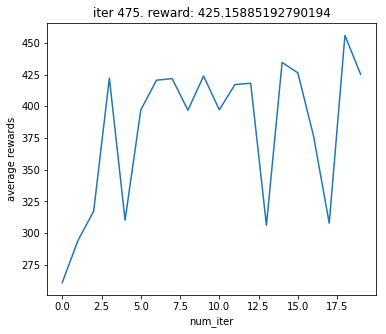

100%|██████████| 500/500 [4:11:23<00:00, 30.17s/it]


In [6]:
image_path = result_path + '/reward_history.png'
test_rewards = []
num_iters = []

state = envs.reset()
early_stop = False

for num_iter in trange(training_iter):
    state = envs.reset()

    log_probs = []
    values    = []
    states    = []
    actions   = []
    rewards   = []
    masks     = []
    entropy = 0

    for _ in range(num_steps):
        state = torch.FloatTensor(state).to(device)
        dist, value = model(state)

        action = dist.sample()
        next_state, reward, done, _ = envs.step(action.cpu().numpy())
        
        log_prob = dist.log_prob(action)
        entropy += dist.entropy().mean()
        
        log_probs.append(log_prob)
        values.append(value)
        rewards.append(torch.FloatTensor(reward).unsqueeze(1).to(device))
        masks.append(torch.FloatTensor(1 - done).unsqueeze(1).to(device))
        
        states.append(state)
        actions.append(action)
        
        state = next_state

    if num_iter % 25 == 0:
        test_reward = np.mean([test_env(env, device, model) for _ in range(3)])
        test_rewards.append(test_reward)
        num_iters.append(num_iter)
        plot_and_save(num_iters, test_rewards, image_path)
        model_path = result_path + '/checkpoint' + str(num_iter) + '.pt'
        torch.save(model.state_dict(), model_path)
        send_line(url, headers, 'epoch: {}'.format(num_iter), image_path)
       
    next_state = torch.FloatTensor(next_state).to(device)
    _, next_value = model(next_state)
    returns = compute_gae(next_value, rewards, masks, values, tau=gae_lambda)

    returns   = torch.cat(returns).detach()
    log_probs = torch.cat(log_probs).detach()
    values    = torch.cat(values).detach()
    states    = torch.cat(states)
    actions   = torch.cat(actions)
    advantage = returns - values
    
    ppo_update(model, optimizer, num_sgd_iter, mini_batch_size, states, actions, log_probs, returns, advantage)

In [6]:
model_path = './result/ppo/2019-04-02-02-06-26/checkpoint475.pt'
model.load_state_dict(torch.load(model_path))
model.eval()

ActorCritic(
  (critic): Sequential(
    (0): Linear(in_features=28, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=25, bias=True)
    (5): ReLU()
    (6): Linear(in_features=25, out_features=1, bias=True)
  )
  (actor): Sequential(
    (0): Linear(in_features=28, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=25, bias=True)
    (5): ReLU()
    (6): Linear(in_features=25, out_features=1, bias=True)
  )
)

In [8]:
env = make_vis_env(benchmark_name)

In [9]:
test_env(env, device, model)

405.7049785111906